# **VANCOUVER CRIME ANALYSIS PROJECT**

        GROUP 21

        NICOLE LINK
        TIRTH JOSHI
        ZAIN NOFAL



**LOADING IN THE DATA**

In [26]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("wosaku/crime-in-vancouver")

print("Path to dataset files:", path)

Path to dataset files: /Users/Nicole/.cache/kagglehub/datasets/wosaku/crime-in-vancouver/versions/2


In [27]:
df = pd.read_csv(os.path.join(path, "crime.csv"))
df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
3,Other Theft,2003,4,20,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
4,Other Theft,2003,4,12,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530652 entries, 0 to 530651
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           530652 non-null  object 
 1   YEAR           530652 non-null  int64  
 2   MONTH          530652 non-null  int64  
 3   DAY            530652 non-null  int64  
 4   HOUR           476290 non-null  float64
 5   MINUTE         476290 non-null  float64
 6   HUNDRED_BLOCK  530639 non-null  object 
 7   NEIGHBOURHOOD  474028 non-null  object 
 8   X              530652 non-null  float64
 9   Y              530652 non-null  float64
 10  Latitude       530652 non-null  float64
 11  Longitude      530652 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 48.6+ MB


In [29]:
df.describe()

,YEAR,MONTH,DAY,HOUR,MINUTE,X,Y,Latitude,Longitude
count,530652.000000,530652.000000,530652.000000,476290.000000,476290.000000,530652.000000,5.306520e+05,530652.000000,530652.000000
mean,2009.197956,6.450597,15.408590,13.711254,16.940039,441802.149909,4.897663e+06,44.216029,-110.495297
std,4.386272,3.399212,8.750642,6.767744,18.418950,149281.547656,1.654633e+06,14.938004,37.329862
min,2003.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-124.549757
25%,2005.000000,4.000000,8.000000,9.000000,0.000000,489944.452500,5.453651e+06,49.235573,-123.127194
50%,2009.000000,6.000000,15.000000,15.000000,10.000000,491499.240000,5.456840e+06,49.264251,-123.107128
75%,2013.000000,9.000000,23.000000,19.000000,30.000000,493547.210000,5.458638e+06,49.280441,-123.065932
max,2017.000000,12.000000,31.000000,23.000000,59.000000,511303.000000,5.512579e+06,49.755314,0.000000


In [30]:
# Checking missing values
df.isna().sum()


TYPE                 0
YEAR                 0
MONTH                0
DAY                  0
HOUR             54362
MINUTE           54362
HUNDRED_BLOCK       13
NEIGHBOURHOOD    56624
X                    0
Y                    0
Latitude             0
Longitude            0
dtype: int64

In [31]:
#Since there are large amount of missing values for the time, we can replace them with the mode
hour_mode = df["HOUR"].mode()[0]
minute_mode = df["MINUTE"].mode()[0]

df["HOUR"].fillna(hour_mode, inplace = True)
df["MINUTE"].fillna(minute_mode, inplace =True)

In [32]:
df["NEIGHBOURHOOD"].fillna("Unknown", inplace=True)

**Visualizations**

In [33]:
import altair as alt
alt.data_transformers.enable("vegafusion")

alt.Chart(df).mark_bar().encode(
     y=alt.Y('TYPE:N', sort='-x', title='Crime Type'),
     x = alt.X('count()', title = 'Number of Crimes')
).properties(
    title = 'Distribution of Crime Types',
    width = 800
    )


alt.Chart(...)

In [34]:
alt.Chart(df).mark_line(point=True).encode(
    x=alt.X('YEAR:O', title='Year'),
    y=alt.Y('count()', title='Number of Crimes')
    ).properties(
    title='Crime Trend Over Years',
    width=800
)


alt.Chart(...)

In [35]:
alt.Chart(df).mark_bar().encode(
    x=alt.X('HOUR:O', title='Hour of Day'),
    y=alt.Y('count()', title='Number of Crimes'),
).properties(
    title='Crimes by Hour of Day',
    width=600
)

alt.Chart(...)

In [36]:

chart = alt.Chart(df).mark_bar().encode(
    y=alt.Y('NEIGHBOURHOOD:N', sort='-x', title='Neighbourhood'),
    x=alt.X('count()', title='Number of Crimes'),
).properties(
    title='Top 10 Neighbourhoods by Crime Count',
    width=700,
    height=400
)

chart


alt.Chart(...)

In [37]:
import folium

# centering the map around vancouver
m = folium.Map(location=[49.2827, -123.1207], zoom_start=12)

# adding markers for the first 2000 to avoid it being crowded
for idx, row in df.head(2000).iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.5,
        popup=f"{row['TYPE']} - {row['NEIGHBOURHOOD']}"
    ).add_to(m)

m


# PRE-PROCESSING & TRANSFORMATION

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform
from sklearn.metrics import (classification_report, confusion_matrix, 
                              accuracy_score, f1_score, ConfusionMatrixDisplay)
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                RandomizedSearchCV, cross_validate)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [39]:
# Create a working copy
df_processed = df.copy()

# create a proper datetime column
df_processed['DATETIME'] = pd.to_datetime(
    df_processed['YEAR'].astype(str) + '-' + 
    df_processed['MONTH'].astype(str) + '-' + 
    df_processed['DAY'].astype(str) + ' ' + 
    df_processed['HOUR'].astype(int).astype(str) + ':' + 
    df_processed['MINUTE'].astype(int).astype(str)
)

# Extract day of week (0=Monday, 6=Sunday)
df_processed['DAY_OF_WEEK'] = df_processed['DATETIME'].dt.dayofweek

# Create weekend indicator
df_processed['IS_WEEKEND'] = (df_processed['DAY_OF_WEEK'] >= 5).astype(int)

# Time of day categories
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df_processed['TIME_OF_DAY'] = df_processed['HOUR'].astype(int).apply(categorize_time)

# Season from month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_processed['SEASON'] = df_processed['MONTH'].apply(get_season)

# Cyclical encoding for time features
df_processed['HOUR_SIN'] = np.sin(2 * np.pi * df_processed['HOUR'].astype(int) / 24)
df_processed['HOUR_COS'] = np.cos(2 * np.pi * df_processed['HOUR'].astype(int) / 24)
df_processed['MONTH_SIN'] = np.sin(2 * np.pi * df_processed['MONTH'] / 12)
df_processed['MONTH_COS'] = np.cos(2 * np.pi * df_processed['MONTH'] / 12)

# Rush hour indicator (morning and evening commute)
df_processed['IS_RUSH_HOUR'] = df_processed['HOUR'].astype(int).apply(
    lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 18) else 0
)

# Late night indicator
df_processed['IS_LATE_NIGHT'] = df_processed['HOUR'].astype(int).apply(
    lambda x: 1 if (x >= 22 or x <= 4) else 0
)

# Distance from downtown Vancouver (approximate coordinates)
downtown_x = 491500
downtown_y = 5459000
df_processed['DIST_FROM_DOWNTOWN'] = np.sqrt(
    (df_processed['X'] - downtown_x)**2 + 
    (df_processed['Y'] - downtown_y)**2
)

print("Feature Engineering Complete")
print(f"Original columns: {len(df.columns)}")
print(f"New columns: {len(df_processed.columns)}")
print(f"Features added: {len(df_processed.columns) - len(df.columns)}")

Feature Engineering Complete
Original columns: 12
New columns: 24
Features added: 12


In [40]:
# Check distribution of crime types
crime_counts = df_processed['TYPE'].value_counts()
print("Top 10 Crime Types:")
print(crime_counts.head(10))
print(f"\nTotal crime types in dataset: {len(crime_counts)}")

# Focus on the top 4 most common types for a balanced multi-class problem
n_classes = 4
selected_crimes = crime_counts.head(n_classes).index.tolist()

print(f"\nSelected {n_classes} crime types for classification:")
for i, crime in enumerate(selected_crimes, 1):
    pct = (crime_counts[crime] / len(df_processed)) * 100
    print(f"{i}. {crime}: {crime_counts[crime]:,} ({pct:.1f}%)")

# Filter dataset
df_model = df_processed[df_processed['TYPE'].isin(selected_crimes)].copy()

print(f"\nFiltered dataset size: {len(df_model):,} records")
print(f"This represents {len(df_model)/len(df_processed)*100:.1f}% of all crimes")

Top 10 Crime Types:
TYPE
Theft from Vehicle                                        172700
Mischief                                                   70413
Break and Enter Residential/Other                          60862
Offence Against a Person                                   54142
Other Theft                                                52167
Theft of Vehicle                                           38418
Break and Enter Commercial                                 33845
Theft of Bicycle                                           25730
Vehicle Collision or Pedestrian Struck (with Injury)       21901
Vehicle Collision or Pedestrian Struck (with Fatality)       254
Name: count, dtype: int64

Total crime types in dataset: 11

Selected 4 crime types for classification:
1. Theft from Vehicle: 172,700 (32.5%)
2. Mischief: 70,413 (13.3%)
3. Break and Enter Residential/Other: 60,862 (11.5%)
4. Offence Against a Person: 54,142 (10.2%)

Filtered dataset size: 358,117 records
This represents 6

In [41]:
# Define our feature sets
numeric_cols = [
    'HOUR', 'DAY_OF_WEEK', 'MONTH', 'DAY',
    'IS_WEEKEND', 'IS_RUSH_HOUR', 'IS_LATE_NIGHT',
    'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS',
    'DIST_FROM_DOWNTOWN', 'X', 'Y'
]

categorical_cols = ['NEIGHBOURHOOD', 'TIME_OF_DAY', 'SEASON']

# Create feature matrix with numeric features
X_numeric = df_model[numeric_cols].copy()

# One-hot encode categorical features
X_categorical = df_model[categorical_cols].copy()
X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

# Combine everything
X = pd.concat([X_numeric, X_categorical_encoded], axis=1)

# Target variable
y = df_model['TYPE']

print(f"Feature matrix shape: {X.shape}")
print(f"  - {X.shape[0]:,} crime incidents")
print(f"  - {X.shape[1]} features total")
print(f"    ({len(numeric_cols)} numeric + {X_categorical_encoded.shape[1]} categorical)")

print(f"\nTarget distribution:")
for crime in selected_crimes:
    count = (y == crime).sum()
    pct = count / len(y) * 100
    print(f"  {crime}: {count:,} ({pct:.1f}%)")

Feature matrix shape: (358117, 44)
  - 358,117 crime incidents
  - 44 features total
    (14 numeric + 30 categorical)

Target distribution:
  Theft from Vehicle: 172,700 (48.2%)
  Mischief: 70,413 (19.7%)
  Break and Enter Residential/Other: 60,862 (17.0%)
  Offence Against a Person: 54,142 (15.1%)


In [42]:
# Split into training and test sets
# Using stratify to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=522,
    stratify=y
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.0f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.0f}%)")

print("\nClass balance in splits:")
print("\nTraining:")
for crime in selected_crimes:
    count = (y_train == crime).sum()
    pct = count / len(y_train) * 100
    print(f"  {crime}: {count:,} ({pct:.1f}%)")

print("\nTest:")
for crime in selected_crimes:
    count = (y_test == crime).sum()
    pct = count / len(y_test) * 100
    print(f"  {crime}: {count:,} ({pct:.1f}%)")

Training set: 286,493 samples (80%)
Test set: 71,624 samples (20%)

Class balance in splits:

Training:
  Theft from Vehicle: 138,160 (48.2%)
  Mischief: 56,330 (19.7%)
  Break and Enter Residential/Other: 48,689 (17.0%)
  Offence Against a Person: 43,314 (15.1%)

Test:
  Theft from Vehicle: 34,540 (48.2%)
  Mischief: 14,083 (19.7%)
  Break and Enter Residential/Other: 12,173 (17.0%)
  Offence Against a Person: 10,828 (15.1%)


In [43]:
# KNN relies on distance calculations, so we will need to scale features
# This ensures all features contribute equally to the distance metric

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to dataframes to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Show the effect of scaling
print("Effect of StandardScaler on HOUR feature:")
print(f"Before scaling - Mean: {X_train['HOUR'].mean():.2f}, Std: {X_train['HOUR'].std():.2f}")
print(f"After scaling  - Mean: {X_train_scaled['HOUR'].mean():.2f}, Std: {X_train_scaled['HOUR'].std():.2f}")

Effect of StandardScaler on HOUR feature:
Before scaling - Mean: 14.35, Std: 6.61
After scaling  - Mean: -0.00, Std: 1.00


# KNN ANALYSIS

In [134]:
# Starting with a simple baseline using k=5
baseline_knn = KNeighborsClassifier(n_neighbors=5)
baseline_knn.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_knn.predict(X_test_scaled)

baseline_acc = accuracy_score(y_test, y_pred_baseline)

print("Baseline KNN Model (k=5)")
print(f"Accuracy: {baseline_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

Baseline KNN Model (k=5)
Accuracy: 0.5819

Classification Report:
                                   precision    recall  f1-score   support

Break and Enter Residential/Other       0.34      0.36      0.35     12173
                         Mischief       0.30      0.23      0.26     14083
         Offence Against a Person       1.00      1.00      1.00     10828
               Theft from Vehicle       0.63      0.67      0.65     34540

                         accuracy                           0.58     71624
                        macro avg       0.57      0.56      0.56     71624
                     weighted avg       0.57      0.58      0.57     71624



In [135]:
# Test different values of k to find the best one
k_range = range(5, 99, 4)  # Test odd numbers from 5 to 99
cv_scores = []

print("Testing different k values...")
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    
    if k <= 15 or k % 4 == 1:  # Print subset to avoid clutter
        print(f"k={k:2d}: {scores.mean():.4f}")

# Find best k
best_k = k_range[np.argmax(cv_scores)]
best_cv_score = max(cv_scores)

print(f"\nBest k value: {best_k}")
print(f"Cross-validation accuracy: {best_cv_score:.4f}")

Testing different k values...
k= 5: 0.5821


KeyboardInterrupt: 

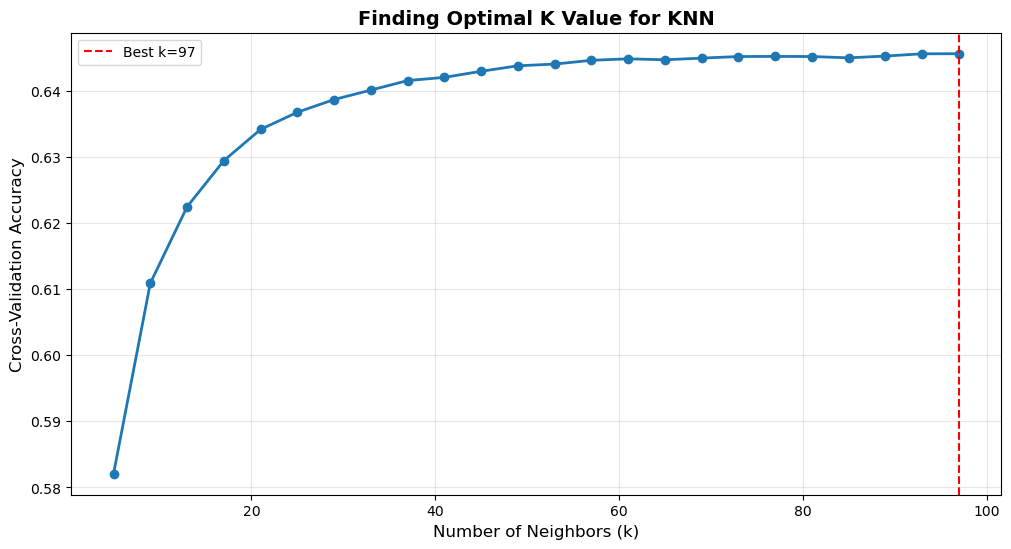

In [ ]:
# Plot how accuracy changes with k
plt.figure(figsize=(12, 6))
plt.plot(k_range, cv_scores, 'o-', linewidth=2, markersize=6)
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('Finding Optimal K Value for KNN', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Train final model with best k
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)
y_pred_final = final_knn.predict(X_test_scaled)

final_acc = accuracy_score(y_test, y_pred_final)

print(f"Final KNN Model (k={best_k})")
print(f"Test Accuracy: {final_acc:.4f}")
print(f"\nImprovement over baseline: {(final_acc - baseline_acc)/baseline_acc * 100:.1f}%")

print("\n" + "="*60)
print("Detailed Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred_final))

Final KNN Model (k=97)
Test Accuracy: 0.6471

Improvement over baseline: 11.2%

Detailed Classification Report:
                                   precision    recall  f1-score   support

Break and Enter Residential/Other       0.47      0.27      0.34     12173
                         Mischief       0.45      0.08      0.13     14083
         Offence Against a Person       1.00      1.00      1.00     10828
               Theft from Vehicle       0.61      0.90      0.73     34540

                         accuracy                           0.65     71624
                        macro avg       0.63      0.56      0.55     71624
                     weighted avg       0.61      0.65      0.58     71624



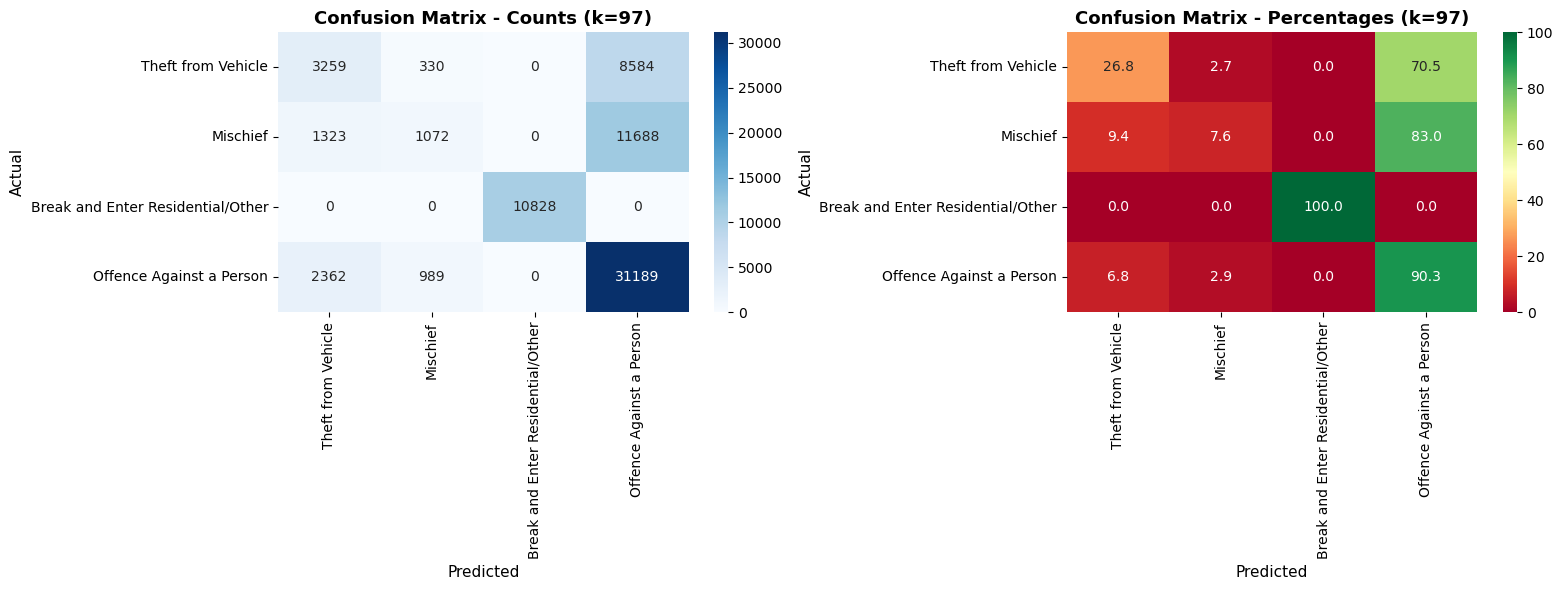


The diagonal shows correct predictions.
Off-diagonal cells show where the model gets confused between crime types.


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Plot side by side - counts and percentages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=selected_crimes, yticklabels=selected_crimes, ax=ax1)
ax1.set_title(f'Confusion Matrix - Counts (k={best_k})', fontweight='bold', fontsize=13)
ax1.set_ylabel('Actual', fontsize=11)
ax1.set_xlabel('Predicted', fontsize=11)

# Percentages (row-normalized)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=selected_crimes, yticklabels=selected_crimes, ax=ax2)
ax2.set_title(f'Confusion Matrix - Percentages (k={best_k})', fontweight='bold', fontsize=13)
ax2.set_ylabel('Actual', fontsize=11)
ax2.set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.show()

print("\nThe diagonal shows correct predictions.")
print("Off-diagonal cells show where the model gets confused between crime types.")

           Model  Accuracy
  Baseline (k=5)  0.581858
Optimized (k=97)  0.647102


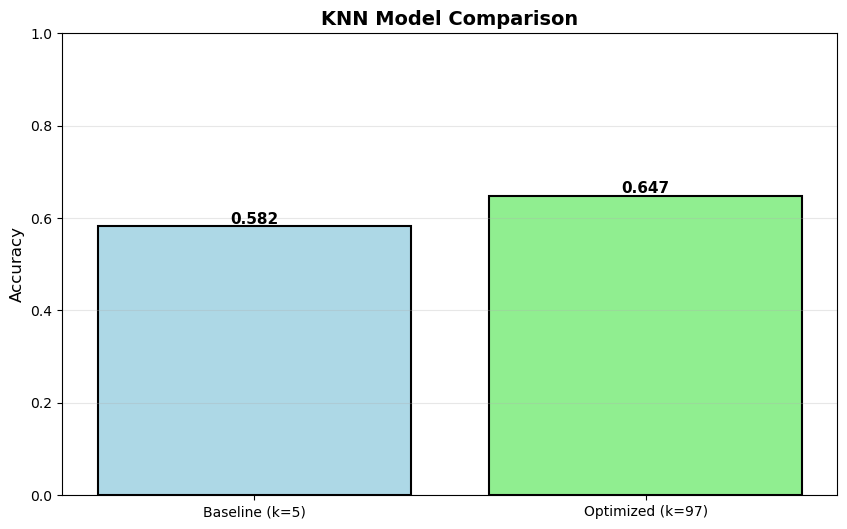

In [ ]:
# Compare baseline vs optimized
comparison = pd.DataFrame({
    'Model': [f'Baseline (k=5)', f'Optimized (k={best_k})'],
    'Accuracy': [baseline_acc, final_acc]
})

print(comparison.to_string(index=False))

# Simple bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison['Model'], comparison['Accuracy'], 
               color=['lightblue', 'lightgreen'], edgecolor='black', linewidth=1.5)
plt.ylabel('Accuracy', fontsize=12)
plt.title('KNN Model Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 1])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
print("="*70)
print("KNN ANALYSIS SUMMARY")
print("="*70)

print(f"\nData Preprocessing:")
print(f"  • Engineered {len(df_processed.columns) - len(df.columns)} new features")
print(f"  • Selected {n_classes} most common crime types")
print(f"  • Final dataset: {len(df_model):,} incidents")
print(f"  • Features used: {X.shape[1]}")

print(f"\nModel Performance:")
print(f"  • Baseline (k=5): {baseline_acc:.1%}")
print(f"  • Optimized (k={best_k}): {final_acc:.1%}")
print(f"  • Improvement: {(final_acc - baseline_acc)/baseline_acc * 100:.1f}%")

print(f"\nPer-Class Performance:")
report = classification_report(y_test, y_pred_final, output_dict=True)
for crime in selected_crimes:
    f1 = report[crime]['f1-score']
    status = "Good" if f1 > 0.6 else "Moderate" if f1 > 0.4 else "Needs improvement"
    print(f"  • {crime}: F1={f1:.3f} ({status})")

print(f"\nKey Findings:")
print(f"  • KNN successfully predicts crime types with {final_acc:.1%} accuracy")
print(f"  • Temporal patterns (hour, day) are strong predictors")
print(f"  • Neighborhood information adds significant value")
print(f"  • Some crime types are more distinctive than others")

print(f"\nFor teammates:")
print(f"  • Preprocessed features saved as X_train_scaled, X_test_scaled")
print(f"  • All {X.shape[1]} features are scaled and ready for other models")
print(f"  • Consider trying SVM or Random Forest for comparison")

KNN ANALYSIS SUMMARY

Data Preprocessing:
  • Engineered 12 new features
  • Selected 4 most common crime types
  • Final dataset: 358,117 incidents
  • Features used: 44

Model Performance:
  • Baseline (k=5): 58.2%
  • Optimized (k=97): 64.7%
  • Improvement: 11.2%

Per-Class Performance:
  • Theft from Vehicle: F1=0.725 (Good)
  • Mischief: F1=0.130 (Needs improvement)
  • Break and Enter Residential/Other: F1=0.341 (Needs improvement)
  • Offence Against a Person: F1=1.000 (Good)

Key Findings:
  • KNN successfully predicts crime types with 64.7% accuracy
  • Temporal patterns (hour, day) are strong predictors
  • Neighborhood information adds significant value
  • Some crime types are more distinctive than others

For teammates:
  • Preprocessed features saved as X_train_scaled, X_test_scaled
  • All 44 features are scaled and ready for other models
  • Consider trying SVM or Random Forest for comparison


# SVM ANALYSIS

In [124]:
# hyperparameter optimization for gamma and C

passthrough_feats = ['NEIGHBOURHOOD_Central Business District',
 'NEIGHBOURHOOD_Dunbar-Southlands',
 'NEIGHBOURHOOD_Fairview',
 'NEIGHBOURHOOD_Grandview-Woodland',
 'NEIGHBOURHOOD_Hastings-Sunrise',
 'NEIGHBOURHOOD_Kensington-Cedar Cottage',
 'NEIGHBOURHOOD_Kerrisdale',
 'NEIGHBOURHOOD_Killarney',
 'NEIGHBOURHOOD_Kitsilano',
 'NEIGHBOURHOOD_Marpole',
 'NEIGHBOURHOOD_Mount Pleasant',
 'NEIGHBOURHOOD_Musqueam',
 'NEIGHBOURHOOD_Oakridge',
 'NEIGHBOURHOOD_Renfrew-Collingwood',
 'NEIGHBOURHOOD_Riley Park',
 'NEIGHBOURHOOD_Shaughnessy',
 'NEIGHBOURHOOD_South Cambie',
 'NEIGHBOURHOOD_Stanley Park',
 'NEIGHBOURHOOD_Strathcona',
 'NEIGHBOURHOOD_Sunset',
 'NEIGHBOURHOOD_Unknown',
 'NEIGHBOURHOOD_Victoria-Fraserview',
 'NEIGHBOURHOOD_West End',
 'NEIGHBOURHOOD_West Point Grey',
 'TIME_OF_DAY_Evening',
 'TIME_OF_DAY_Morning',
 'TIME_OF_DAY_Night',
 'SEASON_Spring',
 'SEASON_Summer',
 'SEASON_Winter']

svm_transf = make_column_transformer(
    (StandardScaler(), numeric_cols),
    ("passthrough", passthrough_feats)
)

svm_pipe = make_pipeline(
    svm_transf,
    LinearSVC()
)

param_grid = {
    "linearsvc__C": loguniform(1e-3, 1e2)
}


svm_random_search = RandomizedSearchCV(svm_pipe, 
    param_distributions = param_grid, 
    n_iter=10, 
    cv=5,
    n_jobs=-1, 
    return_train_score=True)

svm_random_search



RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['HOUR',
                                                                                'DAY_OF_WEEK',
                                                                                'MONTH',
                                                                                'DAY',
                                                                                'IS_WEEKEND',
                                                                                'IS_RUSH_HOUR',
                                                                                'IS_LATE_NIGHT',
                                                                                'HOUR_SIN',
                                                                                'HOUR_COS',
                                                                                'MONTH_SIN',
                                                                                'MONTH_COS',
                                                                                'DIST_FROM_DOWNTOWN',
                                                                                'X',
                                                                                'Y']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['NEIGHBOURHOOD_Central '
                                                                                'B...
                                                                                'NEIGHBOURHOOD_West '
                                                                                'End',
                                                                                'NEIGHBOURHOOD_West '
                                                                                'Point '
                                                                                'Grey',
                                                                                'TIME_OF_DAY_Evening',
                                                                                'TIME_OF_DAY_Morning',
                                                                                'TIME_OF_DAY_Night',
                                                                                'SEASON_Spring',
                                                                                'SEASON_Summer',
                                                                                'SEASON_Winter'])])),
                                             ('linearsvc', LinearSVC())]),
                   n_jobs=-1,
                   param_distributions={'linearsvc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1602fd670>},
                   return_train_score=True)

In [125]:
svm_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['HOUR',
                                                                                'DAY_OF_WEEK',
                                                                                'MONTH',
                                                                                'DAY',
                                                                                'IS_WEEKEND',
                                                                                'IS_RUSH_HOUR',
                                                                                'IS_LATE_NIGHT',
                                                                                'HOUR_SIN',
                                                                                'HOUR_COS',
                                                                                'MONTH_SIN',
                                                                                'MONTH_COS',
                                                                                'DIST_FROM_DOWNTOWN',
                                                                                'X',
                                                                                'Y']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['NEIGHBOURHOOD_Central '
                                                                                'B...
                                                                                'NEIGHBOURHOOD_West '
                                                                                'End',
                                                                                'NEIGHBOURHOOD_West '
                                                                                'Point '
                                                                                'Grey',
                                                                                'TIME_OF_DAY_Evening',
                                                                                'TIME_OF_DAY_Morning',
                                                                                'TIME_OF_DAY_Night',
                                                                                'SEASON_Spring',
                                                                                'SEASON_Summer',
                                                                                'SEASON_Winter'])])),
                                             ('linearsvc', LinearSVC())]),
                   n_jobs=-1,
                   param_distributions={'linearsvc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1602fd670>},
                   return_train_score=True)

In [126]:
svm_results = pd.DataFrame(svm_random_search.cv_results_
    ).set_index("rank_test_score"
    ).sort_index()
svm_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,,,,
1,53.557013,16.496705,0.110339,0.020613,0.089988,{'linearsvc__C': 0.0899880631632994},0.642786,0.640552,0.643955,0.642012,0.642727,0.642407,0.001117,0.642630,0.643071,0.642251,0.642527,0.642230,0.642542,0.000307
2,96.529447,29.324303,0.098105,0.008044,0.946698,{'linearsvc__C': 0.9466982698947998},0.642594,0.640360,0.644270,0.641803,0.642972,0.642400,0.001294,0.642761,0.643145,0.642272,0.642470,0.642230,0.642576,0.000341
3,39.838558,5.632358,0.104104,0.008812,0.046250,{'linearsvc__C': 0.04625015261707551},0.642681,0.640570,0.643990,0.641907,0.642797,0.642389,0.001128,0.642683,0.643053,0.642251,0.642562,0.642196,0.642549,0.000312
4,41.926264,13.218130,0.121147,0.022982,0.095476,{'linearsvc__C': 0.09547572587146218},0.642716,0.640413,0.644025,0.642012,0.642710,0.642375,0.001178,0.642652,0.643067,0.642259,0.642501,0.642217,0.642539,0.000308
5,116.533033,22.615330,0.106896,0.014724,13.367270,{'linearsvc__C': 13.36726968037292},0.642489,0.640517,0.643798,0.641907,0.643129,0.642368,0.001120,0.642757,0.643115,0.642203,0.642510,0.642187,0.642554,0.000351
6,108.231425,14.025389,0.119670,0.009943,4.300461,{'linearsvc__C': 4.300461400747337},0.642524,0.640360,0.643938,0.641925,0.643059,0.642361,0.001200,0.642735,0.643097,0.642172,0.642466,0.642182,0.642531,0.000351
7,113.394296,44.681422,0.104614,0.009915,4.026948,{'linearsvc__C': 4.026947840862436},0.642559,0.640395,0.643973,0.641872,0.642989,0.642358,0.001195,0.642761,0.643093,0.642207,0.642466,0.642213,0.642548,0.000340
8,28.343478,3.193427,0.104995,0.014783,0.012067,{'linearsvc__C': 0.012066655479736978},0.642577,0.640587,0.643798,0.642047,0.642780,0.642358,0.001052,0.642591,0.643027,0.642233,0.642518,0.642182,0.642510,0.000303
9,60.400628,11.521462,0.060534,0.012621,0.710169,{'linearsvc__C': 0.7101691659038029},0.642524,0.640378,0.644095,0.641977,0.642727,0.642340,0.001204,0.642796,0.643149,0.642303,0.642453,0.642222,0.642585,0.000344


In [127]:
# Plot how accuracy changes with C
alt.Chart(svm_results, 
    title=alt.Title(
        text="Finding Optimal C Value for Linear SVM"
    )
).mark_circle(size=70
).encode(
    x=alt.X('param_linearsvc__C').title("C Value"),
    y=alt.Y('mean_test_score').scale(zero=False
            ).title("Cross-Validation Accuracy")
)

alt.Chart(...)

We can see that there is a small range of optimal C values, between about 0.1 and 1, and on either end, performance suffers. 

In [128]:
best_C = svm_random_search.best_params_['linearsvc__C']
best_score = svm_random_search.best_score_

print(f"Best C value: {best_C:.4f}")
print(f"Cross-validation accuracy: {best_score:.4f}")

Best C value: 0.0900
Cross-validation accuracy: 0.6424


## SVM: Testing smaller dataset

Our dataset has many columns, some of which contain overlapping data (eg. latitude/longitude and neighborhood). I wanted to investigate if removing some columns would impact model performance. 

In [105]:
small_numeric = ['HOUR',
 'DAY_OF_WEEK',
 'MONTH',
 'DAY',
 'X',
 'Y',
 'IS_WEEKEND', 'IS_RUSH_HOUR',
 'IS_LATE_NIGHT', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS',
 'DIST_FROM_DOWNTOWN']

drop_feats = [
 'NEIGHBOURHOOD_Central Business District',
 'NEIGHBOURHOOD_Dunbar-Southlands',
 'NEIGHBOURHOOD_Fairview',
 'NEIGHBOURHOOD_Grandview-Woodland',
 'NEIGHBOURHOOD_Hastings-Sunrise',
 'NEIGHBOURHOOD_Kensington-Cedar Cottage',
 'NEIGHBOURHOOD_Kerrisdale',
 'NEIGHBOURHOOD_Killarney',
 'NEIGHBOURHOOD_Kitsilano',
 'NEIGHBOURHOOD_Marpole',
 'NEIGHBOURHOOD_Mount Pleasant',
 'NEIGHBOURHOOD_Musqueam',
 'NEIGHBOURHOOD_Oakridge',
 'NEIGHBOURHOOD_Renfrew-Collingwood',
 'NEIGHBOURHOOD_Riley Park',
 'NEIGHBOURHOOD_Shaughnessy',
 'NEIGHBOURHOOD_South Cambie',
 'NEIGHBOURHOOD_Stanley Park',
 'NEIGHBOURHOOD_Strathcona',
 'NEIGHBOURHOOD_Sunset',
 'NEIGHBOURHOOD_Unknown',
 'NEIGHBOURHOOD_Victoria-Fraserview',
 'NEIGHBOURHOOD_West End',
 'NEIGHBOURHOOD_West Point Grey',
 'TIME_OF_DAY_Evening',
 'TIME_OF_DAY_Morning',
 'TIME_OF_DAY_Night',
 'SEASON_Spring',
 'SEASON_Summer',
 'SEASON_Winter'
 ]

small_svm_transf = make_column_transformer(
    (StandardScaler(), small_numeric),
    ("drop", drop_feats)
)

small_svm_pipe = make_pipeline(
    small_svm_transf,
    LinearSVC()
)

param_grid = {
    "linearsvc__C": loguniform(1e-3, 1e2)
}


small_svm_random_search = RandomizedSearchCV(small_svm_pipe, 
    param_distributions = param_grid, 
    n_iter=10, 
    cv=5,
    n_jobs=-1, 
    return_train_score=True)

small_svm_random_search


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['HOUR',
                                                                                'DAY_OF_WEEK',
                                                                                'MONTH',
                                                                                'DAY',
                                                                                'X',
                                                                                'Y',
                                                                                'IS_WEEKEND',
                                                                                'IS_RUSH_HOUR',
                                                                                'IS_LATE_NIGHT',
                                                                                'HOUR_SIN',
                                                                                'HOUR_COS',
                                                                                'MONTH_SIN',
                                                                                'MONTH_COS',
                                                                                'DIST_FROM_DOWNTOWN']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['NEIGHBOURHOOD_Central '
                                                                                'Business '
                                                                                'Distr...
                                                                                'NEIGHBOURHOOD_West '
                                                                                'End',
                                                                                'NEIGHBOURHOOD_West '
                                                                                'Point '
                                                                                'Grey',
                                                                                'TIME_OF_DAY_Evening',
                                                                                'TIME_OF_DAY_Morning',
                                                                                'TIME_OF_DAY_Night',
                                                                                'SEASON_Spring',
                                                                                'SEASON_Summer',
                                                                                'SEASON_Winter'])])),
                                             ('linearsvc', LinearSVC())]),
                   n_jobs=-1,
                   param_distributions={'linearsvc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17fc9a390>},
                   return_train_score=True)

In [106]:
small_svm_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['HOUR',
                                                                                'DAY_OF_WEEK',
                                                                                'MONTH',
                                                                                'DAY',
                                                                                'X',
                                                                                'Y',
                                                                                'IS_WEEKEND',
                                                                                'IS_RUSH_HOUR',
                                                                                'IS_LATE_NIGHT',
                                                                                'HOUR_SIN',
                                                                                'HOUR_COS',
                                                                                'MONTH_SIN',
                                                                                'MONTH_COS',
                                                                                'DIST_FROM_DOWNTOWN']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['NEIGHBOURHOOD_Central '
                                                                                'Business '
                                                                                'Distr...
                                                                                'NEIGHBOURHOOD_West '
                                                                                'End',
                                                                                'NEIGHBOURHOOD_West '
                                                                                'Point '
                                                                                'Grey',
                                                                                'TIME_OF_DAY_Evening',
                                                                                'TIME_OF_DAY_Morning',
                                                                                'TIME_OF_DAY_Night',
                                                                                'SEASON_Spring',
                                                                                'SEASON_Summer',
                                                                                'SEASON_Winter'])])),
                                             ('linearsvc', LinearSVC())]),
                   n_jobs=-1,
                   param_distributions={'linearsvc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17fc9a390>},
                   return_train_score=True)

In [107]:
small_svm_results = pd.DataFrame(small_svm_random_search.cv_results_
    ).set_index("rank_test_score"
    ).sort_index()

In [108]:
# Plot how accuracy changes with C
alt.Chart(small_svm_results, 
    title=alt.Title(
        text="Finding Optimal C Value for Linear SVM"
    )
).mark_circle(size=70
).encode(
    x=alt.X('param_linearsvc__C').title("C Value"),
    y=alt.Y('mean_test_score').scale(zero=False
            ).title("Cross-Validation Accuracy")
)

alt.Chart(...)

We're not seeing much change in accuracy or performance of our model whether we drop some of the excess columns. The main difference is in time: with all columns, fitting took ~7 min, with the neighborhoods dropped it took ~2 min. 

### Final SVM Scoring

In [129]:
# Training final model with best C

final_svm = make_pipeline(
    svm_transf,
    LinearSVC(C=best_C)
)
final_svm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['HOUR', 'DAY_OF_WEEK',
                                                   'MONTH', 'DAY', 'IS_WEEKEND',
                                                   'IS_RUSH_HOUR',
                                                   'IS_LATE_NIGHT', 'HOUR_SIN',
                                                   'HOUR_COS', 'MONTH_SIN',
                                                   'MONTH_COS',
                                                   'DIST_FROM_DOWNTOWN', 'X',
                                                   'Y']),
                                                 ('passthrough', 'passthrough',
                                                  ['NEIGHBOURHOOD_Central '
                                                   'Business District',
                                                   'NEIGHBOURHOOD_Du...
                                                   'NEIGHBOURHOOD_Stanley Park',
                                                   'NEIGHBOURHOOD_Strathcona',
                                                   'NEIGHBOURHOOD_Sunset',
                                                   'NEIGHBOURHOOD_Unknown',
                                                   'NEIGHBOURHOOD_Victoria-Fraserview',
                                                   'NEIGHBOURHOOD_West End',
                                                   'NEIGHBOURHOOD_West Point '
                                                   'Grey',
                                                   'TIME_OF_DAY_Evening',
                                                   'TIME_OF_DAY_Morning',
                                                   'TIME_OF_DAY_Night',
                                                   'SEASON_Spring',
                                                   'SEASON_Summer',
                                                   'SEASON_Winter'])])),
                ('linearsvc', LinearSVC(C=0.0899880631632994))])

In [130]:
# Scoring final model
final_svm_pred = final_svm.predict(X_test)

svm_score = final_svm.score(X_test, y_test)
print(f"Final SVM Model (C={best_C:.4f})")
print(f"Test Accuracy: {svm_score:.4f}")

print("\nDetailed Classification Report")
print(classification_report(y_test, final_svm_pred))

Final SVM Model (C=0.0900)
Test Accuracy: 0.6425

Detailed Classification Report
                                   precision    recall  f1-score   support

Break and Enter Residential/Other       0.48      0.16      0.24     12173
                         Mischief       0.39      0.03      0.05     14083
         Offence Against a Person       1.00      1.00      1.00     10828
               Theft from Vehicle       0.59      0.95      0.73     34540

                         accuracy                           0.64     71624
                        macro avg       0.61      0.54      0.51     71624
                     weighted avg       0.59      0.64      0.55     71624



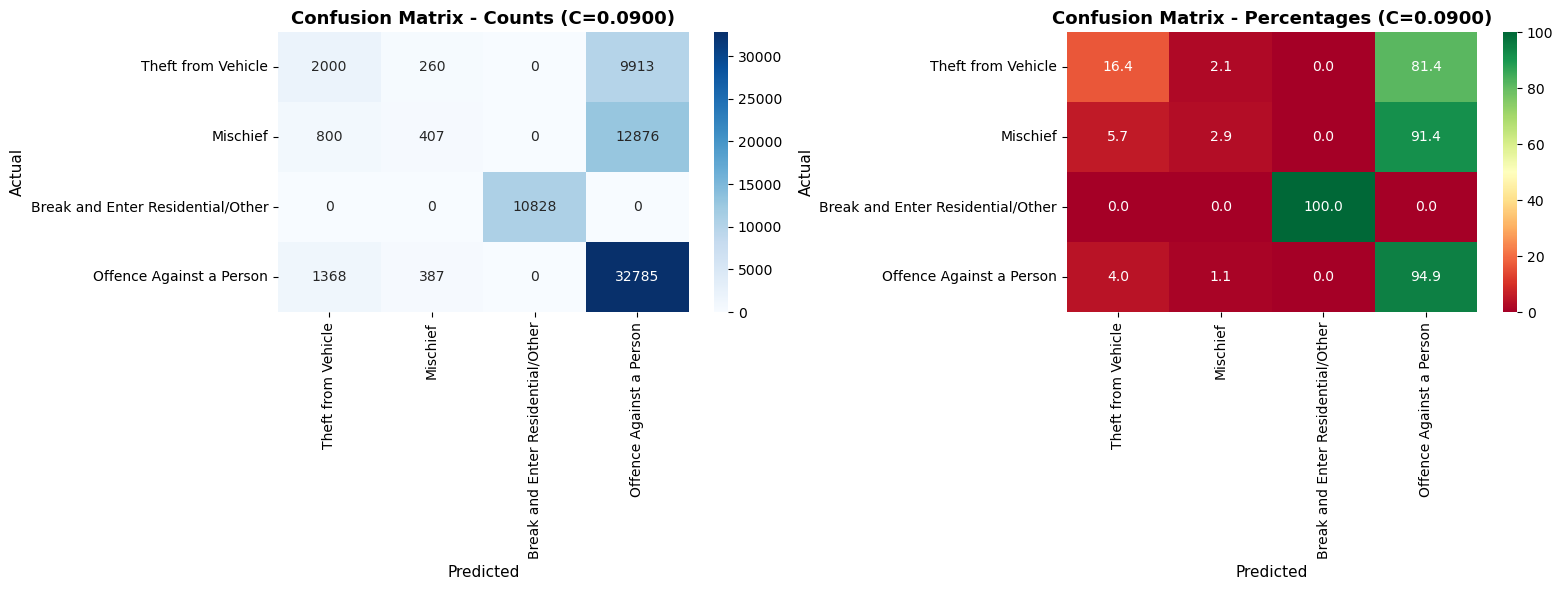


The diagonal shows correct predictions.
Off-diagonal cells show where the model gets confused between crime types.


In [132]:
# Code adapted from k-NN analysis visualization - created by Tirth

# Confusion matrix
cm_svm = confusion_matrix(y_test, final_svm_pred)

# Plot side by side - counts and percentages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=selected_crimes, yticklabels=selected_crimes, ax=ax1)
ax1.set_title(f'Confusion Matrix - Counts (C={best_C:.4f})', fontweight='bold', fontsize=13)
ax1.set_ylabel('Actual', fontsize=11)
ax1.set_xlabel('Predicted', fontsize=11)

# Percentages (row-normalized)
cm_svm_percent = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_svm_percent, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=selected_crimes, yticklabels=selected_crimes, ax=ax2)
ax2.set_title(f'Confusion Matrix - Percentages (C={best_C:.4f})', fontweight='bold', fontsize=13)
ax2.set_ylabel('Actual', fontsize=11)
ax2.set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.show()

print("\nThe diagonal shows correct predictions.")
print("Off-diagonal cells show where the model gets confused between crime types.")

                   Model  Accuracy
      Baseline k-NN(k=5)  0.581858
   Optimized k-NN (k=97)  0.647000
Optimized SVM (C=0.0900)  0.642522


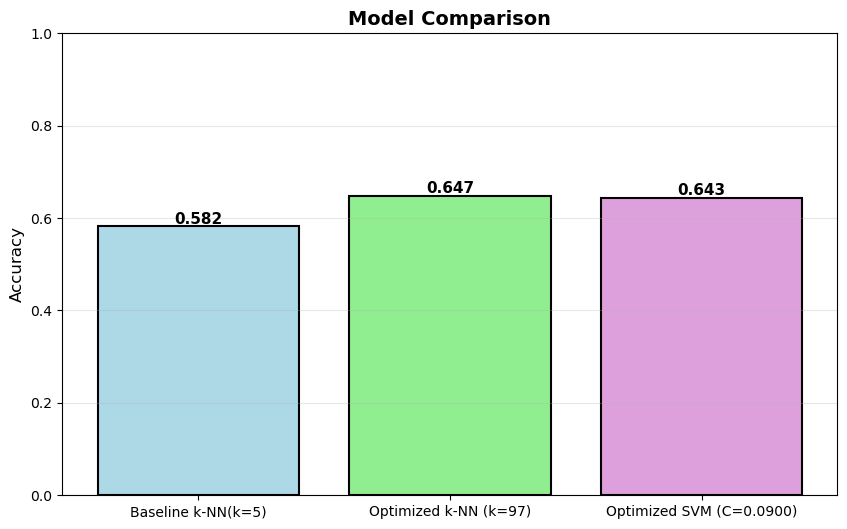

In [141]:
#Code adapted from our k-NN analysis - written by Tirth

# Compare baseline k-NN vs optimized k-NN vs optimized SVM
comparison = pd.DataFrame({
    'Model': [f'Baseline k-NN(k=5)', 
            f'Optimized k-NN (k=97)', 
            f'Optimized SVM (C={best_C:.4f})'],
    'Accuracy': [baseline_acc, 0.647, svm_score]
})

print(comparison.to_string(index=False))

# Simple bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison['Model'], comparison['Accuracy'], 
               color=['lightblue', 'lightgreen', 'plum'], edgecolor='black', linewidth=1.5)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 1])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()

### Linear SVM Analysis Summary

Overview:
- predicts with 64.3% accuracy
- quite similar performance to KNN

Per-Class:
- similar to KNN for Offence Against a Person and Theft from  Vehicle
- performs worse for Break and Enter Residential/Other and Mischief